In [1]:
%pip install tensorflow==2.10 opencv-python matplotlib


  Using cached tensorflow-2.10.0-cp310-cp310-win_amd64.whl (455.9 MB)
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/fb/c4/f574ba6f04e6d7bf8c38d23e7a52389566dd7631fee0bcdd79ea07ef2dbf/opencv_python-4.8.0.76-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python-4.8.0.76-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/7a/94/a1615bac6706eb8a58fe08675b80a11b5463ef9591176dd3e57257495774/matplotlib-3.8.0-cp310-cp310-win_amd64.whl.metadata
Using cached opencv_python-4.8.0.76-cp37-abi3-win_amd64.whl (38.1 MB)
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
    --------------------------------------- 0.1/7.6 MB 3.3 MB/s eta 0:00:03
   - -------------------------------------- 0.3/7.6 MB 3.4 MB/s eta 0:00:03
   -- ------------------------------------- 0.4/7.6 MB 3.9 MB/s eta 0:00:02
   --- ------------------------------------ 0.7/


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Standard dependencies
import cv2
import os
import random
import numpy as np # For re-shaping arrays
from matplotlib import pyplot as plt # Visualise images

# Tensorflow dependencies
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# To avoid running out of memory, we restrict the GPU memory growth aka
# how many resources the model is consuming at any given time
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    # Just in case the device we are using has more than one gpu, we are 
    # making sure to restrict the usage of ALL of them
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[]

In [ ]:
# Create files that will hold the anchor, positive and negative images:
# Anchor: The image we imput
# Positive: Images that match the anchor
# Negative: Images that are different from the anchor
anc_path = os.path.join("data","anchor")
pos_path = os.path.join("data","positive")
neg_path = os.path.join("data","negative")

os.makedirs(anc_path)
os.makedirs(pos_path)
os.makedirs(neg_path)


In [ ]:
# Uncompress the tar file that contains the images in the Wild Dataface
!tar -xf lfw.tgz

In [ ]:
# We take the images that we downloaded and place in the negative folder
# (these images will be used so that the machine can understand that the
# person whose image we are providing isn't the same as any of the ones in
# the negative folder)

# Go through all the directories in the lfw folder
for directory in os.listdir('lfw'):
    # Find all the images in said directory
    for file in os.listdir(os.path.join('lfw',directory)):
        # Replace the path of that image with the path of the negative folder
        # (aka place the image in the negative folder)
        previous_path = os.path.join('lfw', directory, file)
        new_path = os.path.join(neg_path, file)
        os.replace(previous_path, new_path)

In [ ]:
# Importing this so that the images we save  all have different names
import uuid

# Now we will get the images we will require for the anchor and positive files

# Connect to the webcam
capture = cv2.VideoCapture(0) # Keep in mind this number might vary slightly
                              # so try out a few other numbers like 1, 2, 3, 4, 5 etc in case there is a problem
while (capture.isOpened()):
    return_value, frame = capture.read()

    # Keeping in mind that the images in the negative folder have a resolution of 250x250
    # we need out frames (aka the images we will capture) to be 250x250 as well
    frame = frame[120:370, 200:450, :]
    print(frame[2])

    # Show the camera feed
    cv2.imshow("Images", frame)

    # Add image to anchor if 'a' is pressed
    if (cv2.waitKey(1) & 0XFF == ord('a')):
        # Create the unique name and save the image
        name = os.path.join(anc_path, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(name, frame)
    
    # Add image to positive if 'p' is pressed
    if (cv2.waitKey(1) & 0XFF == ord('p')):
        # Create the unique name and save the image
        name = os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(name, frame)

    # Break by pressing he 'q' key
    if (cv2.waitKey(1) & 0XFF == ord('q')):
        break

# Release webcam
capture.release()
# Close the camera feed window
cv2.destroyAllWindows()

In [6]:
# Get 300 image paths from each image set
anchor = tf.data.Dataset.list_files(os.path.join("data","anchor")+'\*.jpg').take(300) # TO_DO Change to path names
positive = tf.data.Dataset.list_files(os.path.join("data","positive")+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(os.path.join("data","negative")+'\*.jpg').take(300)

In [3]:
dir_test = anchor.as_numpy_iterator()

In [4]:
print(dir_test.next())

b'data\\anchor\\2d0f763f-547c-11ee-bf65-38d57a328974.jpg'


In [7]:
# Scale and resize the images
def preprocess(file_path):
    # Get byte code of image (the file path) and then decode it
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)

    img = tf.image.resize(img, (105, 105)) # Resizing out image according to the "Siamese Neural Networks"
                                           # research paper
    img = img / 255.0 # Scale every pixel value to 0-1 => scale the image
    return img

In [6]:
img = preprocess('data\\anchor\\47c0c4c7-547c-11ee-b25f-38d57a328974.jpg')

In [7]:
img.numpy().max() 

1.0

In [8]:
# Depending on the inputs (anchor, positive) or (anchor, negative) we will be
# getting a result ( a label ) as follows:
# (anchor, positive) => 1
# (anchor, negative) => 0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives) # Combine the positives and negatives

In [9]:
samples = data.as_numpy_iterator()

In [10]:
ex = samples.next()


In [11]:
ex

(b'data\\anchor\\2fbb2683-547c-11ee-868c-38d57a328974.jpg',
 b'data\\positive\\5d6e6891-547c-11ee-89b4-38d57a328974.jpg',
 1.0)

In [9]:
# Create function to scale and resize both images we pass
def twin_preprocess(anc, verification_image, label):
    return (preprocess(anc), preprocess(verification_image), label)


In [13]:
res = twin_preprocess(*ex)

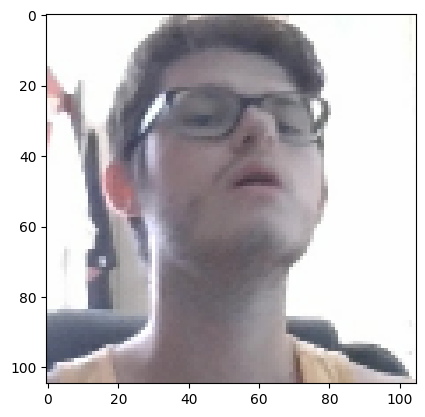

In [14]:
plt.imshow(res[1])

In [15]:
res[2]

1.0

In [10]:
# Dataloader pipeline
data = data.map(twin_preprocess) # ERROR TO_DO
data = data.cache()
data = data.shuffle(buffer_size=1024) # Simply mix the positive and negative images

In [11]:
# Training partition
train_data = data.take((round(len(data)*0.7))) # Get 70% of the samples
train_data = train_data.batch(16) # Pass 16 images each time
train_data = train_data.prefetch(8) # Preprocess the next image beforehand


In [12]:
# Testing Partition
test_data = data.skip((round(len(data)*0.7)))
test_data = test_data.take((round(len(data)*0.3)))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [13]:
# Embedding layer

def make_embedding():
    # Input
    inp = Input(shape=(105, 105, 3), name="input_image")

    # First block
    # Convolusion layer
    c1 = Conv2D(64, (10, 10), activation="relu")(inp)
    # Max pooling layer
    m1  = MaxPooling2D(64, (2, 2), padding="same")(c1)

    # Second block
    c2 = Conv2D(128, (7, 7), activation="relu")(m1)
    m2 = MaxPooling2D(64, (2, 2), padding="same")(c2)

    # Third block
    c3 = Conv2D(128, (4, 4), activation="relu")(m2)
    m3 = MaxPooling2D(64, (2, 2), padding="same")(c3)

    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)

    return Model(inputs=[inp], outputs=[d1], name="embedding")

In [ ]:
inp = Input(shape=(105, 105, 3), name="input_image")
c1 = Conv2D(64, (10, 10), activation="relu")(inp)
m1  = MaxPooling2D(64, (2, 2), padding="same")(c1)
c2 = Conv2D(128, (7, 7), activation="relu")(m1)
m2 = MaxPooling2D(64, (2, 2), padding="same")(c2)
c3 = Conv2D(128, (4, 4), activation="relu")(m2)
m3 = MaxPooling2D(64, (2, 2), padding="same")(c3)
c4 = Conv2D(256, (4, 4), activation="relu")(m3)
f1 = Flatten()(c4) # will output 6*6*256
d1 = Dense(4096, activation="sigmoid")(f1)
mod = Model(inputs=[inp], outputs=[d1], name="embedding")


In [20]:
embedding = make_embedding()

In [21]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 105, 105, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [14]:
# Distance layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    # We input our anchor embedding and either a posivite or negative embedding and output their distance
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [52]:
# Anchor input image
input_image = Input(name="input_img", shape=(105, 105, 3))
# Positive / Negative input image
validation_image = Input(name="validation_img", shape=(105, 105, 3))

inp_emb = embedding(input_image)
val_emb = embedding(validation_image)

siam = L1Dist()
distances = siam(inp_emb, val_emb)

# Classification layer
classifier = Dense(1, activation="sigmoid")(distances)

s = Model(inputs=[input_image, validation_image], outputs=classifier, name="Siamese_Network")

#s.summary()


In [54]:
siam(inp_emb, val_emb)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_4')>

In [15]:
# Siamese model
def make_siamese_model():
    # Anchor input image
    input_image = Input(name="input_img", shape=(105, 105, 3))
    # Positive / Negative input image
    validation_image = Input(name="validation_img", shape=(105, 105, 3))

    # Combine Siamese distance
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation="sigmoid")(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name="Siamese_Network")

In [24]:
siamese_model = make_siamese_model()

In [25]:
siamese_model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]    

In [16]:
# Setup loss function
binary_cross_loss = tf.losses.BinaryCrossentropy() #from_logits=True

In [17]:
# Setup optimizer
opt = tf.keras.optimizers.Adam(1e-4) # 1e - 4 = 0.0001

In [18]:
# Checkpoints
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

NameError: name 'siamese_model' is not defined

In [29]:
test_batch = train_data.as_numpy_iterator()

In [30]:
batch_1 =test_batch.next()

In [31]:
x = batch_1[:2]
y = batch_1[2]

In [32]:
y

array([1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
      dtype=float32)

In [69]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
      floating-point value which either represents a
      [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
      when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
      `from_logits=False`).

    **Recommended Usage:** (set `from_logits=True`)

    With `tf.keras` API:

    ```python
    model.compile(
      loss=tf.keras.losses

In [33]:
batch_1

(array([[[[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.9917834 , 0.9939309 , 0.97964513],
          [0.9893624 , 0.993284  , 0.97003466],
          [0.99607843, 1.        , 0.9764706 ]],
 
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.99607843, 0.998226  , 0.98394024],
          [0.9834934 , 0.98741496, 0.9644258 ],
          [0.99607843, 1.        , 0.9767507 ]],
 
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.99215686, 0.99333286, 0.98196167],
          [0.95957047, 0.9633653 , 0.94413763],
          [0.99607843, 1.        , 0.98039216]],
 
         ...,
 
         [[0.66646886, 0.6129674 , 0.6308012 ],
          [0.66744

In [34]:
# Define the training step for each batch of data based on the following steps:
# 1. Make a prediction
# 2. Calculate loss
# 3. Derive gradients
# 4. Calculate new weights and apply

@tf.function # Compiles the function into callable TensorFlow graph
             # aka it helps train the model efficiently
def train_step(batch):
    with tf.GradientTape() as tape: # Helps us can capture the garients
        # Get anchor  and positive/negative image
        x = batch[:2]  # Each batch cointains 16 anchors, 16 positives/negatives and 16 labels
        # Get label
        y_true = batch[2]

        # Forwar pass
        y_pred = siamese_model(x, training=True) # Make a prediction
                                               # **Training = True is importanyt to activate all the layers
        # Calculate loss
        loss = binary_cross_loss(y_true, y_pred) # Calculate loss (true value, prediction)
    
    # Calculate gradients with respect to the loss
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate update weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [35]:
# Train loop
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print("'n Epoch {}/{}".format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data)) # Optional and simply for the visuals

        # Look through each batch
        for idx, batch in enumerate(data):
            # Run train step
            train_step(batch)
            progbar.update(idx + 1) 

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)




In [36]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)

In [30]:
# Evaluate the model
from tensorflow.python.keras.metrics import Precision, Recall
# Note: Precision demonstrates the proporion of correct positive identifications
#       Recall demostrates the proportion of the ACTUAL positive that were correctly identified

# Get a batch of data
test_input, test_value, y_true = test_data.as_numpy_iterator().next()

In [33]:
y_true

array([1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

In [ ]:
# Make predictions
y_pred = siamese_model.predict([test_input, test_value])

In [ ]:
# Post processing the results (aka we create a threshhold so that any numbers above that 
# become => 1 otherwise => 0)
[1 if prediction > 0.5 else 0 for prediction in y_pred]

# Compare the above list to the labels to see if the outputs match the real results
m = Recall()

# Calculate the recall value
m.update_state(y_true,y_pred)

# Return the recall result (pretty much how accurate the model is)
# 1 = perfect  |   0 = horibble
m.result().numpy()

In [ ]:
# Visualise the results
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_value[0])
plt.show()

In [ ]:
# Save Model

# Save weights
siamese_model.save("siamesemodel.h5")

In [ ]:
# Reload Model
model = tf.keras.models.load_model("siamesemodel.h5", custom_objects={"L1Dist":L1Dist, "BinaryCrossentropy":tf.losses.BinaryCrossentropy})
siamese_model.load_weights

In [ ]:
model.predict([test_input, test_value])